# Short guide to the extreme-H python implementation.

# Dependencies

In [1]:
# Libraries
import pandas as pd 
import numpy as np
from scipy import stats
from scipy.stats import weibull_min,gamma, gengamma, invgamma,halfnorm,halfgennorm,rayleigh,erlang
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import genextreme
from scipy import integrate
from pynverse import inversefunc
import scipy.stats as stats
from scipy.stats import uniform
from scipy.integrate import quad
from scipy.optimize import root_scalar

/home/tiago/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def H_teta(a1, a2, a3, a4, a5, a6):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]

def pdf_HG(y, par):
    t1, t2, t3, t4, t5, t6 = par
    H_val = H_teta(t1, t2, t3, t4, t5, t6)
    y = np.array(y)
    pdfh = 1 / H_val * y**t6 * np.exp(-t1 * y - (t2 * y**t3 + t4)**t5)
    return pdfh

def NumIntH(a1, a2, a3, a4, a5, a6):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]

def NumIntH_distribution(a1, a2, a3, a4, a5, a6, y):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, y)[0]

def distribution_extreme_H(x, par):
    t1, t2, t3, t4, t5, t6 = par
    c_theta = NumIntH(t1, t2, t3, t4, t5, t6)
   
    cdf_vec = [0.]*len(x)
    
    for index, val in enumerate(x):
        cdf_vec[index] = (1./c_theta) * NumIntH_distribution(t1, t2, t3, t4, t5, t6, val)

    return cdf_vec

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y
    
# cost/loss function
def ecdf_error(params, data):
    x_empirical, y_empirical = ecdf(data)
    y_theoretical = distribution_extreme_H(x_empirical, params)
    error = np.sum((y_empirical - y_theoretical) ** 2)
    return error

def distribution_extreme_H_ks(x):
    t1, t2, t3, t4, t5, t6 = parGlobal
    c_theta = NumIntH(t1, t2, t3, t4, t5, t6)
   
    cdf_vec = [0.]*len(x)
    
    for index, val in enumerate(x):
        if val==0:
            cdf_vec[index] = 0
        elif np.isnan(val):
            cdf_vec[index] = 0
        else:
            # print('val =', val)
            cdf_vec[index] = (1./c_theta) * NumIntH_distribution(t1, t2, t3, t4, t5, t6, val)

    return cdf_vec

In [3]:
#density function
#y: data set
def dg(y, theta1, theta2, theta3, theta4, theta5, theta6):
    # print('DG theta1=', theta1, type(theta1))
    # print('DG y=', y, type(y))
    c_theta = NumIntH(theta1, theta2, theta3, theta4, theta5, theta6)
    return (1./c_theta)*(y**theta6)*np.exp(-theta1*y-((theta2*y**theta3)+theta4)**theta5)

#log-likelihood function
#x0: data set
def llf(x, t1, t2, t3, t4, t5, t6):

    # print('llf pre-filter x=', x)

    x0=x[dg(x, t1, t2, t3, t4, t5, t6)>0]

    # print('llf pos-filter x0=', x0, 'x<=0: ', x[dg(x, t1, t2, t3, t4, t5, t6)<=0])
    return (sum(np.log(dg(x0, t1, t2, t3, t4, t5, t6))))

def minus_llf(params, data):
    t1, t2, t3, t4, t5, t6 = params
    return -1*llf(data, t1, t2, t3, t4, t5, t6)
    
def eval_fit_extreme(samples, parameters_tuple, no_print=True):
      
    logLik = llf(samples, parameters_tuple[0], parameters_tuple[1], parameters_tuple[2], parameters_tuple[3], parameters_tuple[4], parameters_tuple[5])

    k = len(parameters_tuple)
    aic = 2*k - 2*(logLik)
    n = np.log(len(samples))
    aicc = aic + 2*k*(k+1)/(n-k-1)

    bic = k*n-2*logLik
    edc = -2*logLik-k*np.log(n)

    if(no_print):
        print('AIC: ', aic, 'AICc:', aicc, 'BIC: ', bic, 'EDC:', edc,'Log-Likelihood', logLik)

    parGlobal = parameters_tuple
    
    ks = stats.kstest(samples, distribution_extreme_H_ks)

    if(no_print):
        print('KS :', ks)
    
    return aic, aicc, bic, edc, logLik

In [46]:
# Generator and PPF

def _distribution_extreme_H_priv(x, theta1, theta2, theta3, theta4, theta5, theta6):
    
    if isinstance(x, float):      
        
        # print(x)
        
        if x==0:
            return 0
            
        c_theta = NumIntH(theta1, theta2, theta3, theta4, theta5, theta6)
        return (1./c_theta)*NumIntH_distribution(theta1, theta2, theta3, theta4, theta5, theta6, x)
    else:
        return distribution_extreme_H(x, [theta1, theta2, theta3, theta4, theta5, theta6])

def inversefunc2(theta1, theta2, theta3, theta4, theta5, theta6,target):
    sol = root_scalar(lambda x, *args: _distribution_extreme_H_priv(x, *args) - target,
                      bracket=(0,1000),# coloquei um limite superior alto, mas da pra estimar a partir dos parametros, eventualmente.
                      args=(theta1, theta2, theta3, theta4, theta5, theta6))
    return sol.root

def extreme_H_rvs2(theta_vec, size=1):
    theta1 = theta_vec[0]
    theta2 = theta_vec[1]
    theta3 = theta_vec[2]
    theta4 = theta_vec[3]
    theta5 = theta_vec[4]
    theta6 = theta_vec[5]

    y_values = uniform.rvs(loc=0.0001,scale=0.9998,size=size)

    inv_vals = [inversefunc2(theta1, theta2, theta3, theta4, theta5, theta6,y) for y in y_values]

    return np.array(inv_vals)
    
def extreme_H_ppf(samples, theta_vec):
    theta1 = theta_vec[0]
    theta2 = theta_vec[1]
    theta3 = theta_vec[2]
    theta4 = theta_vec[3]
    theta5 = theta_vec[4]
    theta6 = theta_vec[5]
    my_F_distribution = (lambda x: _distribution_extreme_H_priv(x, theta1, theta2, theta3, theta4, theta5, theta6))
    
    y_values = samples
    
    return inversefunc(my_F_distribution, y_values=y_values)

# Examples

In [48]:
def plot_pdf(parameters_tuple, atitle, xlabel):    
    
    fig, ax = plt.subplots(1, 1)
    
    x=np.arange(1, 100)

    pdf_values = pdf_HG(x, parameters_tuple)

    ax.plot(x, pdf_values, 'r-', lw=5, alpha=0.6)
    ax.set_xlim([x[0], x[-1]])
       
    plt.title(atitle,fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('pdf', fontsize=14)
    plt.show()
        
    return

def plot_cdf(parameters_tuple, atitle, xlabel):    
    
    fig, ax = plt.subplots(1, 1)
    
    x=np.arange(1, 100)

    pdf_values = distribution_extreme_H(x, parameters_tuple)

    ax.plot(x, pdf_values, 'r-', lw=5, alpha=0.6)
    ax.set_xlim([x[0], x[-1]])
       
    plt.title(atitle,fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('cdf', fontsize=14)
    plt.show()
        
    return

## Plotting PDF and CDF from a parameter tuple

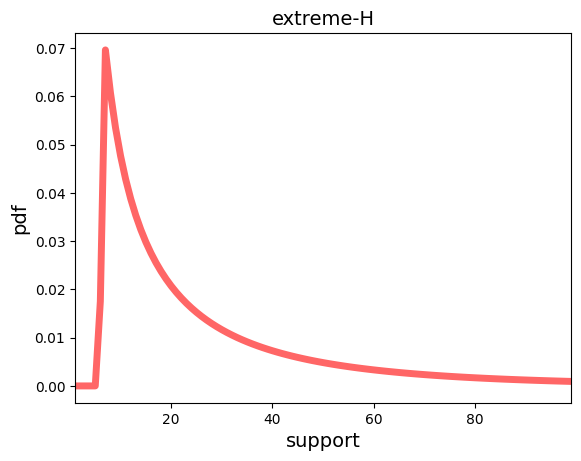

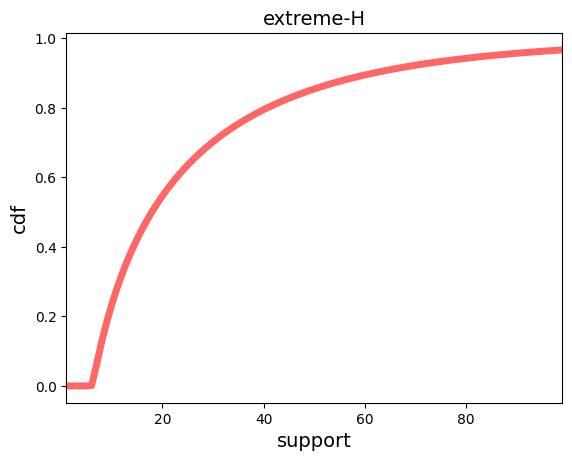

In [50]:
plot_pdf( [2.10280344e-02,  7.67695842e-04,  3.97317286e+00,  7.11604099e-03, -9.50968970e+00, -8.99142058e-01], 'extreme-H', 'support')

plot_cdf( [2.10280344e-02,  7.67695842e-04,  3.97317286e+00,  7.11604099e-03, -9.50968970e+00, -8.99142058e-01], 'extreme-H', 'support')

## Taking a parameter tuple to generate samples

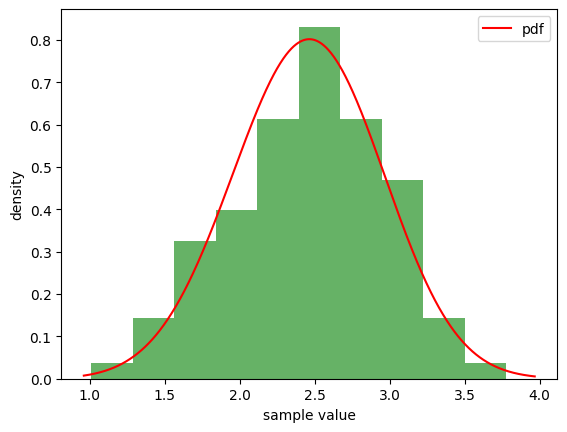

In [44]:
#parameters_tuple = [2.10280344e-02,  7.67695842e-04,  3.97317286e+00,  7.11604099e-03, -9.50968970e+00, -8.99142058e-01]
parameters_tuple = [2.55584476e-05, 6.43480671e-01, 6.27314530e-01, 1.83895256e-02, 5.40854354e+00, 7.15147852e+00]

sample = extreme_H_rvs2(parameters_tuple, 100)

# print(sample)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(0.95*min(sample), 1.05*max(sample), 1000)
pdf_values = pdf_HG(x, parameters_tuple)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

## Trying Algorithms 1 and 2 from a sample.
### Remark: we need a initial guess to start both algorithms.
#### For Algorithm 1, we can take a particular case (from Table 1) that fits data  

In [51]:
X = sample
bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-10, 50)]

# we need an initial guess: it is recommended to come from particular cases (Table 1)
initial_params = [0.2, 0.1, 3, 0.1, -9 , -1]

# LSE ECDF vs CDF: Algorithm 1
result = minimize(ecdf_error, initial_params, args=(X,), bounds=bounds, method='Nelder-Mead')
optimal_params = result.x

print("[Algorithm 1] ECDF optimized parameters:", optimal_params)

# MLE: Algorithm 2 (using n-tuple from Algorithm 1)
result = minimize(minus_llf, optimal_params, args=(np.asarray(X),), bounds=bounds, method='Nelder-Mead')
optimal_params_llf = result.x

print("[Algorithm 2] MLE Optimized Parameters:", optimal_params_llf)

[Algorithm 1] ECDF optimized parameters: [ 5.70063371  0.0227415   0.379461    0.         -1.12801489 -7.66837677]
[Algorithm 2] MLE Optimized Parameters: [ 9.99973105e+00  4.53689743e-03  3.84430478e-01  1.42298900e-02
 -1.37259356e+00 -9.92772392e+00]


AIC:  160.75811678921875 AICc: 125.68255546601972 BIC:  176.3891379051473 EDC: 139.59503903437133 Log-Likelihood -74.37905839460937
KS : KstestResult(statistic=0.05636991014005395, pvalue=0.8904697617282495, statistic_location=1.8339763087857468, statistic_sign=1)
AIC:  2212.160965524354 AICc: 2177.085404201155 BIC:  2227.7919866402826 EDC: 2190.9978877695066 Log-Likelihood -1100.080482762177
KS : KstestResult(statistic=0.05636991014005395, pvalue=0.8904697617282495, statistic_location=1.8339763087857468, statistic_sign=1)
AIC:  170.99754724433436 AICc: 135.92198592113533 BIC:  186.6285683602629 EDC: 149.83446948948693 Log-Likelihood -79.49877362216718
KS : KstestResult(statistic=0.05636991014005395, pvalue=0.8904697617282495, statistic_location=1.8339763087857468, statistic_sign=1)
AIC:  165.4219285715243 AICc: 130.34636724832527 BIC:  181.05294968745284 EDC: 144.2588508166769 Log-Likelihood -76.71096428576215
KS : KstestResult(statistic=0.05636991014005395, pvalue=0.8904697617282495,

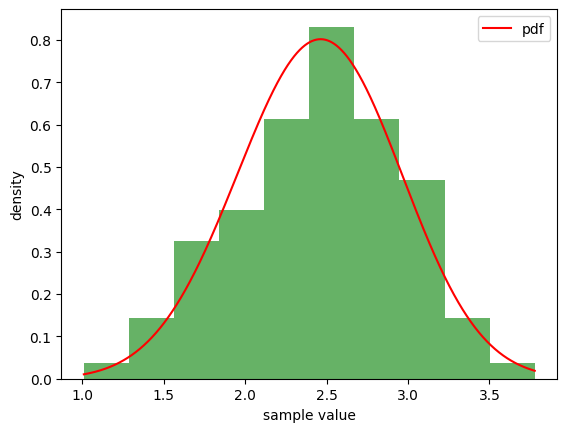

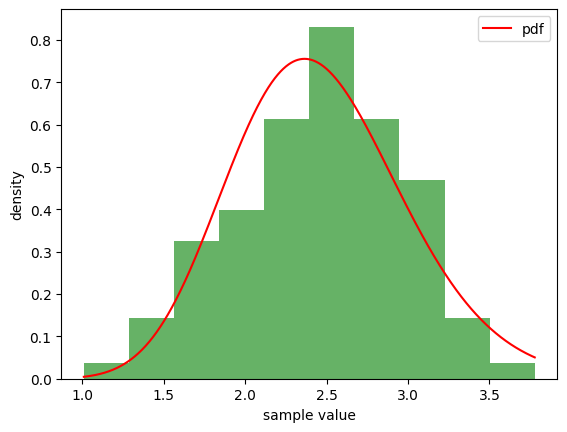

In [52]:
data = sample

generated_params = parameters_tuple

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, generated_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, initial_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params_llf)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(min(sample), max(sample), 1000)
pdf_values = pdf_HG(x, generated_params)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(min(sample), max(sample), 1000)
pdf_values = pdf_HG(x, optimal_params_llf)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

# Frechet

In [4]:
# Piracicaba River dataset
# P. L. Ramos, F. Louzada, E. Ramos, and S. Dey. The fréchet distribution: Estimation and application - an overview. Journal of Statistics and Management Systems, 23(3):549–578, 2020
september_flow = [29.19, 8.49, 7.37, 82.93, 44.18, 13.82, 22.28, 28.06, 6.84, 12.14, 153.78, 17.04, 13.47, 15.43, 30.36, 6.91, 22.12, 35.45, 44.66, 95.81, 6.18, 10.00, 58.39, 24.05, 17.03, 38.65, 47.17, 27.99, 11.84, 9.60, 6.72, 13.74, 14.60, 9.65, 10.39, 60.14, 15.51, 14.69, 16.44]


# Frechet
base_distribution = stats.invweibull

X = september_flow
X_parameters = base_distribution.fit(X, floc=0)


print('X ', X_parameters)
print('X &', min(X),' & ', np.percentile(X,25), ' & ', np.median(X), ' & ', np.mean(X), ' & ', np.percentile(X,75), ' & ', max(X), ' & ', len(X))

X  (1.5644948551004678, 0, 13.76067644260458)
X & 6.18  &  11.115  &  16.44  &  28.284871794871798  &  32.905  &  153.78  &  39


In [5]:
bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-10, 50)]

sigma = X_parameters[2]
shape = X_parameters[0]
initial_params = [0, 1/sigma, 1, 0, -shape, -shape-1]

print(X)

print('shape =', shape, ' scale=', sigma)
print('initial guess ', initial_params)

# LSE ECDF vs CDF: Algorithm 1
result = minimize(ecdf_error, initial_params, args=(X,), bounds=bounds, method='Nelder-Mead')
optimal_params = result.x

print("[Algorithm 1] ECDF optimized parameters:", optimal_params)

# MLE: Algorithm 2 (using n-tuple from Algorithm 1)
result = minimize(minus_llf, optimal_params, args=(np.asarray(X),), bounds=bounds, method='Nelder-Mead')
optimal_params_llf = result.x

print("[Algorithm 2] MLE Optimized Parameters:", optimal_params_llf)

[29.19, 8.49, 7.37, 82.93, 44.18, 13.82, 22.28, 28.06, 6.84, 12.14, 153.78, 17.04, 13.47, 15.43, 30.36, 6.91, 22.12, 35.45, 44.66, 95.81, 6.18, 10.0, 58.39, 24.05, 17.03, 38.65, 47.17, 27.99, 11.84, 9.6, 6.72, 13.74, 14.6, 9.65, 10.39, 60.14, 15.51, 14.69, 16.44]
shape = 1.5644948551004678  scale= 13.76067644260458
initial guess  [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 1] ECDF optimized parameters: [ 1.30923457e-02  3.63820093e-01  5.16540683e-01  6.02528066e-04
 -5.08883272e+00 -1.44633923e+00]
[Algorithm 2] MLE Optimized Parameters: [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]


## Table 3 (line 1)

In [6]:
# AIC, BIC and EDC

X_parameters = [1.5644948551004678,  0, 13.76067644260458]
shape = X_parameters[0]
sigma = X_parameters[2]
reference_params = [0, 1/sigma, 1, 0, -shape, -shape-1]

optimal_params_vec = [ [ 1.30923457e-02,  3.63820093e-01,  5.16540683e-01,  6.02528066e-04, -5.08883272e+00, -1.44633923e+00],
                      [ 2.10280344e-02,  7.67695842e-04,  3.97317286e+00,  7.11604099e-03, -9.50968970e+00, -8.99142058e-01]  ]

a1 = np.float64(reference_params[0])
a2 = np.float64(reference_params[1])
a3 = np.float64(reference_params[2])
a4 = np.float64(reference_params[3])
a5 = np.float64(reference_params[4])
a6 = np.float64(reference_params[5])

data=np.array(X)

print('Frechet data =', data)

for tuple in optimal_params_vec:
    
    optimal_params = tuple

    print("Reference parameters:", reference_params)
    
    # Imprimir os parâmetros otimizados
    print("Optimal parameters:", optimal_params)       
    
    # referencia
    print('reference')
    parGlobal = reference_params
    aic, aicc, bic, edc, logLik = eval_fit_extreme(data, [a1, a2, a3, a4, a5, a6])
    
    print('fitted')
    parGlobal = optimal_params
    aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params)

    print('\n')

Frechet data = [ 29.19   8.49   7.37  82.93  44.18  13.82  22.28  28.06   6.84  12.14
 153.78  17.04  13.47  15.43  30.36   6.91  22.12  35.45  44.66  95.81
   6.18  10.    58.39  24.05  17.03  38.65  47.17  27.99  11.84   9.6
   6.72  13.74  14.6    9.65  10.39  60.14  15.51  14.69  16.44]
Reference parameters: [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
Optimal parameters: [0.0130923457, 0.363820093, 0.516540683, 0.000602528066, -5.08883272, -1.44633923]
reference
AIC:  333.69480197665627 AICc: 308.51825408613166 BIC:  343.67617185343414 EDC: 313.9041871671185 Log-Likelihood -160.84740098832813
KS : KstestResult(statistic=0.07841473668358723, pvalue=0.9548579573017629, statistic_location=27.99, statistic_sign=-1)
fitted
AIC:  332.33626799893693 AICc: 307.15972010841233 BIC:  342.3176378757148 EDC: 312.54565318939916 Log-Likelihood -160.16813399946847
KS : KstestResult(statistic=0.07175396740489254, pvalue=0.9793882843819256, statistic_location=13.47, stat

# Weilbull

In [7]:
# The data represent the strength data measured in GPA, for single carbon fibers. Single fibers were tested under tension at gauge length of 20 mm. 69 samples
# R. Valiollahi, A. Asgharzadeh, and M. Z. Raqab. Estimation of P (Y < X) for Weibull distribution under progressive Type-II censoring. Communications in Statistics-Theory and Methods, 42(24):4476–4498, 2013.
Y_carbon_fiber = [1.312,1.314,1.479,1.552,1.700,1.803,1.861,1.865,1.944,1.958,1.966,1.997,2.006,2.021,2.027,2.055, 2.063,2.098,2.140,2.179,2.224,2.240,2.253,2.270,2.272,2.274,2.301,2.301,2.359,2.382,2.382,2.426, 2.434,2.435,2.478,2.490,2.511,2.514,2.535,2.554,2.566,2.570,2.586,2.629,2.633,2.642,2.648,2.684, 2.697,2.726,2.770,2.773,2.800,2.809,2.818,2.821,2.848,2.880,2.954,3.012,3.067,3.084,3.090,3.096, 3.128,3.233,3.433,3.585,3.585]

base_distribution = stats.weibull_min

Y = Y_carbon_fiber

Y_parameters = base_distribution.fit(Y, floc=0)

print('Y ', Y_parameters)
print('Y &', min(Y),' & ', np.percentile(Y,25), ' & ', np.median(Y), ' & ', np.mean(Y), ' & ', np.percentile(Y,75), ' & ', max(Y), ' & ', len(Y))

Y  (5.504860090269867, 0, 2.650855606967049)
Y & 1.312  &  2.098  &  2.478  &  2.4513333333333334  &  2.773  &  3.585  &  69


In [8]:
bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (0, 50)]


shape = Y_parameters[0]
sigma = Y_parameters[2]

# Weibull
initial_params = [0, 1/sigma, 1, 0, shape, shape-1]


print('shape =', shape, ' scale=', sigma)
print('initial guess ', initial_params)

# ECDF vs CDF
x_empirical, y_empirical = ecdf(Y)


# LSE ECDF vs CDF: Algorithm 1
result = minimize(ecdf_error, initial_params, args=(Y,), bounds=bounds, method='L-BFGS-B')

optimal_params = result.x

print("[Algorithm 1] ECDF optimized parameters:", optimal_params)

# MLE: Algorithm 2 (using n-tuple from Algorithm 1)
result = minimize(minus_llf, optimal_params, args=(np.asarray(Y),), bounds=bounds, method='L-BFGS-B')
optimal_params_llf = result.x

print("[Algorithm 2] MLE Optimized Parameters:", optimal_params_llf)

y_theoretical = distribution_extreme_H(x_empirical, optimal_params)
y_theoretical_llf = distribution_extreme_H(x_empirical, optimal_params_llf)

shape = 5.504860090269867  scale= 2.650855606967049
initial guess  [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867]
[Algorithm 1] ECDF optimized parameters: [2.22412378e-03 4.99892765e-01 8.03443114e-01 3.12033933e-02
 5.43824247e+00 6.12402375e+00]
[Algorithm 2] MLE Optimized Parameters: [2.55584476e-05 6.43480671e-01 6.27314530e-01 1.83895256e-02
 5.40854354e+00 7.15147852e+00]


/tmp/ipykernel_150354/2413022882.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


## Table 3 (line 2)

In [9]:
reference_params =  [0, np.float64(0.37723669194646947), 1, 0, np.float64(5.504860090269867), np.float64(4.504860090269867)]

# optimized
optimal_params_vec = [ optimal_params,
                     optimal_params_llf]

a1 = np.float64(reference_params[0])
a2 = np.float64(reference_params[1])
a3 = np.float64(reference_params[2])
a4 = np.float64(reference_params[3])
a5 = np.float64(reference_params[4])
a6 = np.float64(reference_params[5])

data=np.array(Y)

print('data =', data)

for tuple in optimal_params_vec:
    
    optimal_params = tuple

    print("Reference parameters:", reference_params)
    
    # Imprimir os parâmetros otimizados
    print("Optimal parameters:", optimal_params)       
    
    # referencia
    print('reference')
    parGlobal = reference_params
    aic, aicc, bic, edc, logLik = eval_fit_extreme(data, [a1, a2, a3, a4, a5, a6])
    
    print('fitted')
    parGlobal = optimal_params
    aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params)

    print('\n')

data = [1.312 1.314 1.479 1.552 1.7   1.803 1.861 1.865 1.944 1.958 1.966 1.997
 2.006 2.021 2.027 2.055 2.063 2.098 2.14  2.179 2.224 2.24  2.253 2.27
 2.272 2.274 2.301 2.301 2.359 2.382 2.382 2.426 2.434 2.435 2.478 2.49
 2.511 2.514 2.535 2.554 2.566 2.57  2.586 2.629 2.633 2.642 2.648 2.684
 2.697 2.726 2.77  2.773 2.8   2.809 2.818 2.821 2.848 2.88  2.954 3.012
 3.067 3.084 3.09  3.096 3.128 3.233 3.433 3.585 3.585]
Reference parameters: [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867]
Optimal parameters: [2.22412378e-03 4.99892765e-01 8.03443114e-01 3.12033933e-02
 5.43824247e+00 6.12402375e+00]
reference
AIC:  111.1922702651877 AICc: 80.82233731599119 BIC:  124.59690929277126 EDC: 90.53323630318033 Log-Likelihood -49.59613513259385
KS : KstestResult(statistic=0.056129327685893515, pvalue=0.9730632666899052, statistic_location=2.821, statistic_sign=1)
fitted
AIC:  110.34667430479332 AICc: 79.97674135559681 BIC:  123.75131333237688 EDC: 89.68764034278595 Log-L

# Gamma

In [10]:
# J. F. Lawless. Statistical models and methods for lifetime data. John Wiley & Sons, 2011.
# W. B. Nelson. Applied Life Data Analysis. John Wiley & Sons, 2005.

Z = [620,470,260,89,388,242, 103,100,39,460,284,1285, 218,393,106,158,152,477, 403,103,69,158,818,947, 399,1274,32,12,134,660, 548,381,203,871,193,531, 317,85,1410,250,41,1101, 32,421,32,343,376,1512, 1792,47,95,76,515,72, 1585,253,6,860,89,1055, 537,101,385,176,11,565, 164,16,1267,352,160,195, 1279,356,751,500,803,560, 151,24,689,1119,1733,2194, 763,555,14,45,776,1, 1747,945,12,1453,14,150, 20,41,35,69,195,89, 1090,1868,294,96,618,44, 142,892,1307,310,230,30, 403,860,23,406,1054,1935, 561,348,130,13,230,250, 317,304,79,1793,536,12, 9,256,201,733,510,660, 122,27,273,1231,182,289, 667,761,1096,43,44,87, 405,998,1409,61,278,407, 113,25,940,28,848,41, 646,575,219,303,304,38, 195,1061,174,377,388,10, 246,323,198,234,39,308, 55,729,813,1216,1618,539, 6,1566,459,946,764,794, 35,181,147,116,141,19, 380,609,546]

print(len(Z))
print(Z)
data2 = Z

print('Z &', min(X),' & ', np.percentile(X,25), ' & ', np.median(X), ' & ', np.mean(X), ' & ', np.percentile(X,75), ' & ', max(X), ' & ', len(X))

201
[620, 470, 260, 89, 388, 242, 103, 100, 39, 460, 284, 1285, 218, 393, 106, 158, 152, 477, 403, 103, 69, 158, 818, 947, 399, 1274, 32, 12, 134, 660, 548, 381, 203, 871, 193, 531, 317, 85, 1410, 250, 41, 1101, 32, 421, 32, 343, 376, 1512, 1792, 47, 95, 76, 515, 72, 1585, 253, 6, 860, 89, 1055, 537, 101, 385, 176, 11, 565, 164, 16, 1267, 352, 160, 195, 1279, 356, 751, 500, 803, 560, 151, 24, 689, 1119, 1733, 2194, 763, 555, 14, 45, 776, 1, 1747, 945, 12, 1453, 14, 150, 20, 41, 35, 69, 195, 89, 1090, 1868, 294, 96, 618, 44, 142, 892, 1307, 310, 230, 30, 403, 860, 23, 406, 1054, 1935, 561, 348, 130, 13, 230, 250, 317, 304, 79, 1793, 536, 12, 9, 256, 201, 733, 510, 660, 122, 27, 273, 1231, 182, 289, 667, 761, 1096, 43, 44, 87, 405, 998, 1409, 61, 278, 407, 113, 25, 940, 28, 848, 41, 646, 575, 219, 303, 304, 38, 195, 1061, 174, 377, 388, 10, 246, 323, 198, 234, 39, 308, 55, 729, 813, 1216, 1618, 539, 6, 1566, 459, 946, 764, 794, 35, 181, 147, 116, 141, 19, 380, 609, 546]
Z & 6.18  &  11.1

In [11]:
bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-10, 50)]

shape, loc, scale = gamma.fit(data2, floc=0)  

alpha = shape
beta =  1 / scale  

initial_params = [beta, 0, 1, 0, 1, shape-1]

initial_params_opt = [np.float64(0.0014600180926046908), np.float64(7.168558250732656), np.float64(-6.554152619274005), np.float64(0.0017861406540565223), np.float64(8.57484235581811), np.float64(-0.29244892768030395)]

print('Initial guess for MLE (from hyperopt)', initial_params_opt)

# MLE: Algorithm 2 (using n-tuple from Algorithm 1 (from hyperopt))
result = minimize(minus_llf, initial_params_opt, args=(np.asarray(data2),), bounds=bounds, method='L-BFGS-B')
optimal_params_llf = result.x

print("[Algorithm 2] MLE Optimized Parameters:", optimal_params_llf)

Initial guess for MLE (from hyperopt) [0.0014600180926046908, 7.168558250732656, -6.554152619274005, 0.0017861406540565223, 8.57484235581811, -0.29244892768030395]
[Algorithm 2] MLE Optimized Parameters: [ 1.74250452e-03  7.16891521e+00 -6.55335632e+00  4.56743472e-03
  8.57482224e+00 -1.94769801e-01]


## Table 3 (line 3)

In [12]:

reference_params = [beta, 0, 1, 0, 1, shape-1]

# optimized
optimal_params_vec = [ [np.float64(0.0014600180926046908), np.float64(7.168558250732656), np.float64(-6.554152619274005), np.float64(0.0017861406540565223), np.float64(8.57484235581811), np.float64(-0.29244892768030395)],
                     [ 1.74250452e-03,  7.16891521e+00, -6.55335632e+00,  4.56743472e-03,  8.57482224e+00, -1.94769801e-01]]

a1 = np.float64(reference_params[0])
a2 = np.float64(reference_params[1])
a3 = np.float64(reference_params[2])
a4 = np.float64(reference_params[3])
a5 = np.float64(reference_params[4])
a6 = np.float64(reference_params[5])


data=np.array(data2)

print('Z =', data, '\n')

for tuple in optimal_params_vec:
    
    optimal_params = tuple

    print("Reference parameters: (special case)", reference_params)
    
    # Imprimir os parâmetros otimizados
    print("Optimal parameters:", optimal_params)
    
    
    print('reference: special case')
    parGlobal = [a1, a2, a3, a4, a5, a6]
    aic, aicc, bic, edc, logLik = eval_fit_extreme(data, [a1, a2, a3, a4, a5, a6])
    
    print('fitted')
    parGlobal = optimal_params
    aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params)

    print('\n')

Z = [ 620  470  260   89  388  242  103  100   39  460  284 1285  218  393
  106  158  152  477  403  103   69  158  818  947  399 1274   32   12
  134  660  548  381  203  871  193  531  317   85 1410  250   41 1101
   32  421   32  343  376 1512 1792   47   95   76  515   72 1585  253
    6  860   89 1055  537  101  385  176   11  565  164   16 1267  352
  160  195 1279  356  751  500  803  560  151   24  689 1119 1733 2194
  763  555   14   45  776    1 1747  945   12 1453   14  150   20   41
   35   69  195   89 1090 1868  294   96  618   44  142  892 1307  310
  230   30  403  860   23  406 1054 1935  561  348  130   13  230  250
  317  304   79 1793  536   12    9  256  201  733  510  660  122   27
  273 1231  182  289  667  761 1096   43   44   87  405  998 1409   61
  278  407  113   25  940   28  848   41  646  575  219  303  304   38
  195 1061  174  377  388   10  246  323  198  234   39  308   55  729
  813 1216 1618  539    6 1566  459  946  764  794   35  181  147  116
  